#Author: Md Mintu Miah, PhD; Post Doctoral Researcher at PATH, UC Berkeley
#Project: Contract 65A0911: Complete Cities: Bicycle Network Connectivity Evaluation Methodology
#PI: Alex Skabardonis, PhD, Professor, UC Berkeley

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections.abc import Mapping
from distutils.version import LooseVersion
from pybna import Importer
import geopandas as gpd
import pybna

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\geopandas\_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pybna\conf.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


In [3]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import fiona
from shapely.ops import unary_union
import networkx as nx
import itertools
import osmnx as ox
import math
import momepy
import matplotlib.pyplot as plt
from shapely.geometry import Point
import io

In [7]:
%%time
# Import Configuration file
i = pybna.Importer(config="config.yaml")
# Import Study Area boundary shape file
i.import_boundary('City_of_Davis_Boundary.shp', overwrite=True)
# Mention the State fips, for California it is 6
i.import_census_blocks(fips=6, overwrite=True)
i.import_census_jobs("received.neighborhood_census_block_jobs",state="CA", overwrite=True)

Connecting to database
Copying boundary to database
Loading boundary
Loading data from http://www2.census.gov/geo/tiger/TIGER2010BLKPOPHU/tabblock2010_06_pophu.zip
Filtering blocks to boundary
Filtering out water
Copying blocks to database
Loading data for state CA
No data for state CA for year 2020. Checking previous year.
Copying jobs to database
CPU times: total: 1min 42s
Wall time: 11min 45s


In [8]:
%%time
i.import_osm_network(overwrite=True)

Copying OSM ways to database
Copying OSM intersections to database
Processing OSM data in database
CPU times: total: 30.8 s
Wall time: 2min 15s


In [9]:
%%time
# stress
s = pybna.Stress(config='config.yaml')
s.segment_stress()
s.crossing_stress()

Connecting to database
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
Calculating stress on shared streets
Calculating stress on streets with bike lanes
Calculating stress on streets with cycle tracks
Calculating stress on paths
  ....forward
  ....backward
CPU times: total: 359 ms
Wall time: 5.57 s


In [4]:
# Read the LTS shape file
lts=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/neighborhood_ways.shp")
lts = lts.rename(columns={'OSMID':'osmid'})
lts=lts.rename({'INTERSECTI':'u', 'INTERSE_01':'v'}, axis='columns')
lts['length']=lts.length
lts.head()

ROAD_ID        osmid FUNCTIONAL PATH_ID ONE_WAY     u     v  WIDTH  \
0     7898  {249414350}  secondary    None    None  1718   559    NaN   
1    14841  {617716534}    primary    None      ft  2267  3616    NaN   
2    15576   {10747435}   tertiary    None    None  1912  3766    NaN   
3    15659  {248096977}       path    None    None  1982  4081    NaN   
4    15999  {990990070}       path    None    None  5222  1000    NaN   

   SPEED_LIMI FT_BIKE_IN  ... TWLTL_CROS FT_PARK TF_PARK  FT_SEG_STR  \
0         NaN       None  ...       None       ?       ?           4   
1         NaN       lane  ...       None       ?       ?           3   
2         NaN       None  ...       None       ?       ?           4   
3         NaN       path  ...       None       ?       ?           1   
4         NaN       path  ...       None       ?       ?           1   

   FT_INT_STR TF_SEG_STR TF_INT_STR XWALK  \
0         NaN        4.0        NaN  None   
1         NaN        NaN        1.0  None   
2         NaN        4.0        NaN  None   
3         NaN        1.0        1.0  None   
4         1.0        1.0        NaN  None   

                                            geometry     length  
0  LINESTRING (110671.553 112905.829, 110715.995 ...  44.448339  
1  LINESTRING (113878.653 113808.321, 113883.431 ...  13.615555  
2  LINESTRING (102682.700 112651.800, 102647.627 ...  35.073038  
3  LINESTRING (109564.470 112068.503, 109601.328 ...  37.430131  
4  LINESTRING (108623.643 111974.308, 108625.263 ...   5.706566  

[5 rows x 27 columns]

# Lets calculate the slope for each link

In [5]:
#https://pysal.org/scipy2019-intermediate-gds/deterministic/gds2-rasters.html
import rasterio
from rasterio.plot import show
from rasterio import plot as rioplot
import matplotlib.pyplot as plt

EPSG:4269


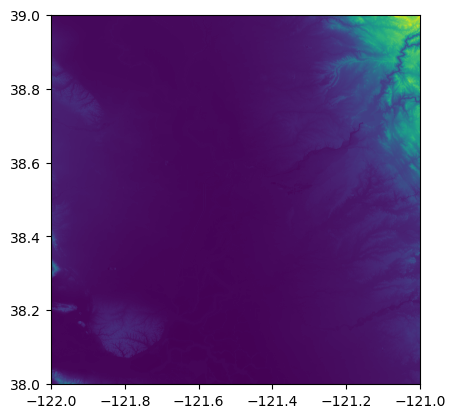

<AxesSubplot:>

In [6]:
# Open the raster image
barea_slope = rasterio.open('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/slope/USGS_13_n39w122_20220206.tif')
print(barea_slope.crs)
rioplot.show(barea_slope)

In [7]:
# only band is elev value (in m)
band1 = barea_slope.read(1, masked=True)  # mask noData cells [shouldn't be necessary on land]
stats = {'min': band1.min(), 'mean': band1.mean(), 'max': band1.max()}
print(stats)

{'min': -7.3393726, 'mean': 42.889994523835824, 'max': 681.56647}


In [8]:
# Reproject the geometries by replacing the values with projected ones
lts_new = lts.to_crs(epsg=4326)
lts_new.head(10)

ROAD_ID                            osmid     FUNCTIONAL PATH_ID ONE_WAY  \
0     7898                      {249414350}      secondary    None    None   
1    14841                      {617716534}        primary    None      ft   
2    15576                       {10747435}       tertiary    None    None   
3    15659                      {248096977}           path    None    None   
4    15999                      {990990070}           path    None    None   
5     7542                      {617716524}      secondary    None      ft   
6     7531                      {683304805}      secondary    None      ft   
7      316  {25354528,617922203,1060523183}      secondary    None      ft   
8      326                       {10745041}  motorway_link    None      ft   
9      258                     {1063803867}  motorway_link    None      ft   

      u     v  WIDTH  SPEED_LIMI FT_BIKE_IN  ... TWLTL_CROS FT_PARK TF_PARK  \
0  1718   559    NaN         NaN       None  ...       None       ?       ?   
1  2267  3616    NaN         NaN       lane  ...       None       ?       ?   
2  1912  3766    NaN         NaN       None  ...       None       ?       ?   
3  1982  4081    NaN         NaN       path  ...       None       ?       ?   
4  5222  1000    NaN         NaN       path  ...       None       ?       ?   
5  5523  2451    NaN         NaN       None  ...       None       ?       ?   
6   744  1688    NaN         NaN       lane  ...       None       ?       ?   
7  1535  2554    NaN        35.0       None  ...       None       ?       ?   
8  5974  5364    NaN         NaN       None  ...       None       ?       ?   
9  1339  4978    NaN         NaN       None  ...       None       ?       ?   

   FT_SEG_STR  FT_INT_STR TF_SEG_STR TF_INT_STR XWALK  \
0           4         NaN        4.0        NaN  None   
1           3         NaN        NaN        1.0  None   
2           4         NaN        4.0        NaN  None   
3           1         NaN        1.0        1.0  None   
4           1         1.0        1.0        NaN  None   
5           4         1.0        NaN        1.0  None   
6           3         1.0        NaN        1.0  None   
7           4         NaN        NaN        NaN  None   
8           4         1.0        NaN        NaN  None   
9           4         3.0        NaN        3.0  None   

                                            geometry      length  
0  LINESTRING (-121.73108 38.54875, -121.73057 38...   44.448339  
1  LINESTRING (-121.69421 38.55664, -121.69416 38...   13.615555  
2  LINESTRING (-121.82274 38.54698, -121.82314 38...   35.073038  
3  LINESTRING (-121.74386 38.54128, -121.74343 38...   37.430131  
4  LINESTRING (-121.75466 38.54050, -121.75464 38...    5.706566  
5  LINESTRING (-121.70958 38.56418, -121.70957 38...    9.852736  
6  LINESTRING (-121.70532 38.55668, -121.70527 38...   10.342277  
7  LINESTRING (-121.76732 38.54645, -121.76773 38...  115.355111  
8  LINESTRING (-121.76739 38.59493, -121.76746 38...  561.788633  
9  LINESTRING (-121.76980 38.53677, -121.76981 38...   13.810277  

[10 rows x 27 columns]

In [9]:
# get the slope for each link of the network
%time
lts_new
# First identify the starting and ending node of each link
lts_new['starting point'] = None
lts_new['ending point'] = None

for index, row in lts_new.iterrows():
    coords = [(coords) for coords in list(row['geometry'].coords)]
    first_coord, last_coord = [ coords[i] for i in (0, -1) ]
    lts_new.at[index,'starting point'] = Point(first_coord)
    lts_new.at[index,'ending point'] = Point(last_coord)
    lts_new

CPU times: total: 0 ns
Wall time: 0 ns


<AxesSubplot:>

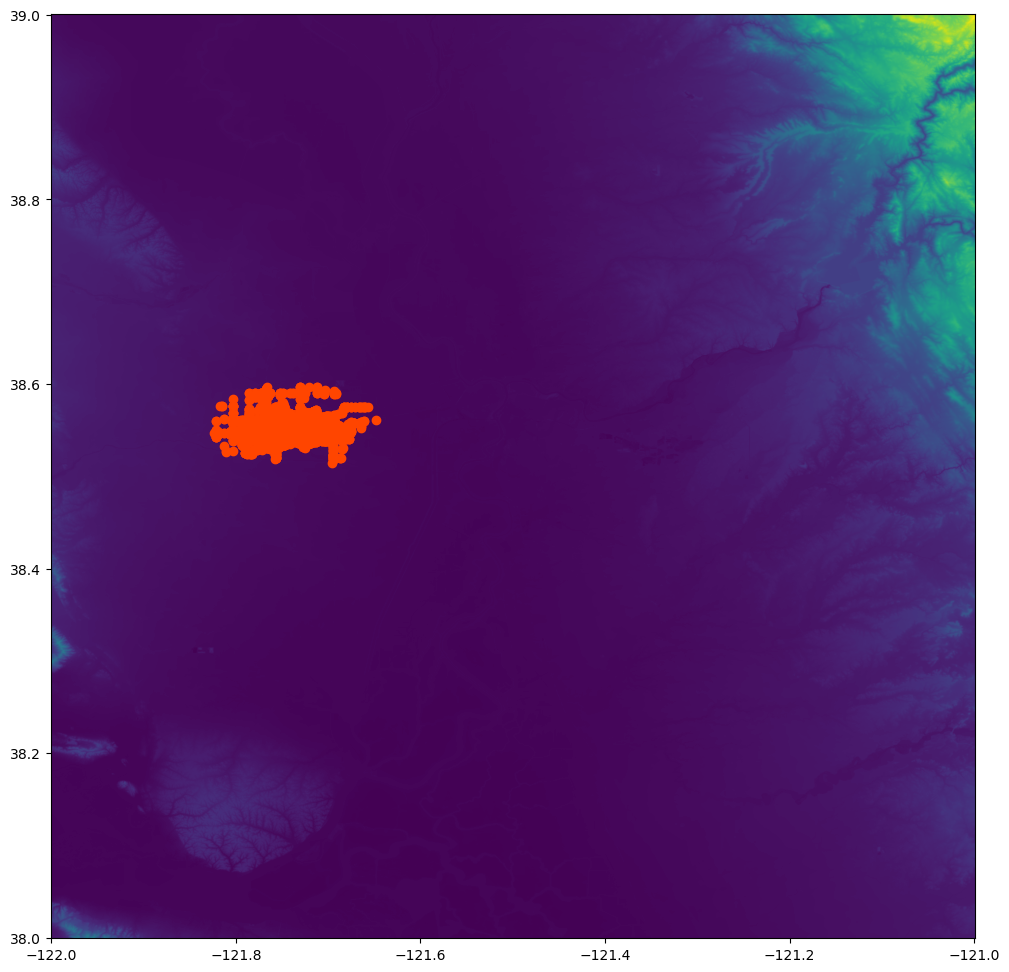

In [10]:
#show point and raster on a matplotlib plot
fig, ax = plt.subplots(figsize=(12,12))
lts_new.boundary.plot(ax=ax, color='orangered')
show(barea_slope, ax=ax)

In [11]:
# Calculate each link starting lat and long
sf1=lts_new.loc[:,["ROAD_ID","starting point"]]
sf1.columns=["ROAD_ID","geometry"]
sf1['start_lon'] = sf1.geometry.apply(lambda p: p.x)
sf1['start_lat'] = sf1.geometry.apply(lambda p: p.y)
sf2=sf1.loc[:,["ROAD_ID","geometry","start_lon","start_lat"]]
sf2.head(5)

ROAD_ID                                 geometry   start_lon  start_lat
0     7898    POINT (-121.731084 38.54874530000001) -121.731084  38.548745
1    14841   POINT (-121.69421260000001 38.5566429) -121.694213  38.556643
2    15576          POINT (-121.8227399 38.5469839) -121.822740  38.546984
3    15659   POINT (-121.74385640000001 38.5412802) -121.743856  38.541280
4    15999  POINT (-121.7546551 38.540496299999994) -121.754655  38.540496

In [12]:
# Calculate each link starting elevation
sf2["starting_ele"]= None
#point in test['geometry']:
x = sf2["start_lon"]
y = sf2["start_lat"]
row, col = barea_slope.index(x,y)
sf2["starting_ele"]=barea_slope.read(1)[row,col]

In [13]:
%%time
# Calculate each link end point elevation
ef1=lts_new.loc[:,["ROAD_ID","ending point"]]
ef1.columns=["ROAD_ID","geometry"]
ef1['end_lon'] = ef1.geometry.apply(lambda p: p.x)
ef1['end_lat'] = ef1.geometry.apply(lambda p: p.y)
ef2=ef1.loc[:,["ROAD_ID","geometry","end_lon","end_lat"]]
ef2.head(5)

CPU times: total: 172 ms
Wall time: 175 ms


ROAD_ID                                geometry     end_lon    end_lat
0     7898  POINT (-121.73057430000001 38.5487355) -121.730574  38.548735
1    14841          POINT (-121.694159 38.5565277) -121.694159  38.556528
2    15576         POINT (-121.8231422 38.5469857) -121.823142  38.546986
3    15659  POINT (-121.74343309999999 38.5413364) -121.743433  38.541336
4    15999   POINT (-121.754637 38.54044690000001) -121.754637  38.540447

In [14]:
%%time
# Calculate the each link end elevation
ef2["ending_ele"]= None
#point in test['geometry']:
x = ef2["end_lon"]
y = ef2["end_lat"]
row, col = barea_slope.index(x,y)
ef2["ending_ele"]=barea_slope.read(1)[row,col]

CPU times: total: 281 ms
Wall time: 274 ms


In [15]:
%%time
# Calculate the slope for each link
from functools import reduce
barea_all=[sf2,ef2,lts_new]

barea_all1= reduce(lambda  left,right: pd.merge(left,right,on=['ROAD_ID'],
                                            how='outer'), barea_all).fillna('0')
barea_all1["slope"]=abs((barea_all1['starting_ele']-barea_all1['ending_ele'])/barea_all1['length'])*100
barea_all1=barea_all1.drop_duplicates(subset=['ROAD_ID'], keep='first')
barea_all1.head()

CPU times: total: 93.8 ms
Wall time: 99.4 ms


ROAD_ID                               geometry_x   start_lon  start_lat  \
0     7898    POINT (-121.731084 38.54874530000001) -121.731084  38.548745   
1    14841   POINT (-121.69421260000001 38.5566429) -121.694213  38.556643   
2    15576          POINT (-121.8227399 38.5469839) -121.822740  38.546984   
3    15659   POINT (-121.74385640000001 38.5412802) -121.743856  38.541280   
4    15999  POINT (-121.7546551 38.540496299999994) -121.754655  38.540496   

   starting_ele                              geometry_y     end_lon  \
0     12.312861  POINT (-121.73057430000001 38.5487355) -121.730574   
1      8.930607          POINT (-121.694159 38.5565277) -121.694159   
2     23.069754         POINT (-121.8231422 38.5469857) -121.823142   
3     15.718659  POINT (-121.74343309999999 38.5413364) -121.743433   
4     14.410607   POINT (-121.754637 38.54044690000001) -121.754637   

     end_lat  ending_ele        osmid  ... FT_SEG_STR FT_INT_STR TF_SEG_STR  \
0  38.548735   12.072841  {249414350}  ...          4          0        4.0   
1  38.556528    8.957235  {617716534}  ...          3          0          0   
2  38.546986   23.181372   {10747435}  ...          4          0        4.0   
3  38.541336   15.605118  {248096977}  ...          1          0        1.0   
4  38.540447   14.439425  {990990070}  ...          1        1.0        1.0   

   TF_INT_STR  XWALK                                           geometry  \
0           0      0  LINESTRING (-121.73108 38.54875, -121.73057 38...   
1         1.0      0  LINESTRING (-121.69421 38.55664, -121.69416 38...   
2           0      0  LINESTRING (-121.82274 38.54698, -121.82314 38...   
3         1.0      0  LINESTRING (-121.74386 38.54128, -121.74343 38...   
4           0      0  LINESTRING (-121.75466 38.54050, -121.75464 38...   

      length                           starting point  \
0  44.448339    POINT (-121.731084 38.54874530000001)   
1  13.615555   POINT (-121.69421260000001 38.5566429)   
2  35.073038          POINT (-121.8227399 38.5469839)   
3  37.430131   POINT (-121.74385640000001 38.5412802)   
4   5.706566  POINT (-121.7546551 38.540496299999994)   

                             ending point     slope  
0  POINT (-121.73057430000001 38.5487355)  0.539999  
1          POINT (-121.694159 38.5565277)  0.195574  
2         POINT (-121.8231422 38.5469857)  0.318245  
3  POINT (-121.74343309999999 38.5413364)  0.303343  
4   POINT (-121.754637 38.54044690000001)  0.504983  

[5 rows x 38 columns]

<AxesSubplot:>

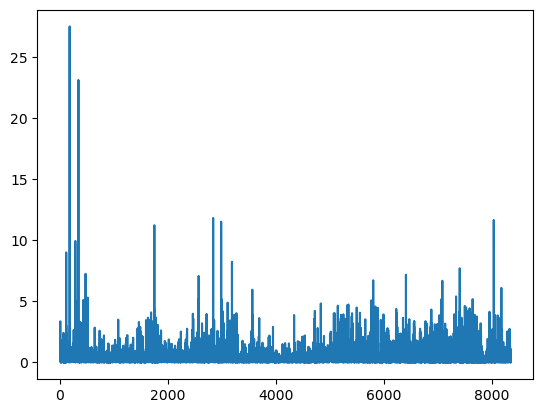

In [16]:
barea_all1.slope.plot()

In [17]:
# write a slope impedance function
def slope_correction(length,FT_SEG_STR,slope):
    if slope <=2:
        return length*(1+FT_SEG_STR)
    elif ((slope>2) and (slope<=4)):
        return length*(1+0.37+FT_SEG_STR)
    elif ((slope>4) and (slope<=6)):
        return length*(1+1.20+FT_SEG_STR)
    else:
        return length*(1+3.20+FT_SEG_STR)

In [18]:
#barea_all1['FT_SEG_STR'].astype(str).astype(int)
barea_all1['FT_SEG_STR']=pd.to_numeric(barea_all1['FT_SEG_STR']).astype(int)
barea_all1['FT_SEG_STR'].dtypes

dtype('int32')

In [19]:
barea_all1['impedance_of_link']=barea_all1.apply(lambda row: slope_correction(row['length'],row['FT_SEG_STR'],row['slope']),axis=1)
barea_all1.head(8)

ROAD_ID                               geometry_x   start_lon  start_lat  \
0     7898    POINT (-121.731084 38.54874530000001) -121.731084  38.548745   
1    14841   POINT (-121.69421260000001 38.5566429) -121.694213  38.556643   
2    15576          POINT (-121.8227399 38.5469839) -121.822740  38.546984   
3    15659   POINT (-121.74385640000001 38.5412802) -121.743856  38.541280   
4    15999  POINT (-121.7546551 38.540496299999994) -121.754655  38.540496   
5     7542           POINT (-121.709577 38.5641801) -121.709577  38.564180   
6     7531          POINT (-121.7053166 38.5566835) -121.705317  38.556683   
7      316   POINT (-121.7673155 38.54645360000001) -121.767315  38.546454   

   starting_ele                              geometry_y     end_lon  \
0     12.312861  POINT (-121.73057430000001 38.5487355) -121.730574   
1      8.930607          POINT (-121.694159 38.5565277) -121.694159   
2     23.069754         POINT (-121.8231422 38.5469857) -121.823142   
3     15.718659  POINT (-121.74343309999999 38.5413364) -121.743433   
4     14.410607   POINT (-121.754637 38.54044690000001) -121.754637   
5     11.815551  POINT (-121.7095656 38.56409179999999) -121.709566   
6     10.277437  POINT (-121.70527450000002 38.5567706) -121.705275   
7     18.179966  POINT (-121.7686386 38.54646249999999) -121.768639   

     end_lat  ending_ele                            osmid  ... FT_INT_STR  \
0  38.548735   12.072841                      {249414350}  ...          0   
1  38.556528    8.957235                      {617716534}  ...          0   
2  38.546986   23.181372                       {10747435}  ...          0   
3  38.541336   15.605118                      {248096977}  ...          0   
4  38.540447   14.439425                      {990990070}  ...        1.0   
5  38.564092   12.147692                      {617716524}  ...        1.0   
6  38.556771   10.217400                      {683304805}  ...        1.0   
7  38.546462   18.410713  {25354528,617922203,1060523183}  ...          0   

  TF_SEG_STR TF_INT_STR  XWALK  \
0        4.0          0      0   
1          0        1.0      0   
2        4.0          0      0   
3        1.0        1.0      0   
4        1.0          0      0   
5          0        1.0      0   
6          0        1.0      0   
7          0          0      0   

                                            geometry      length  \
0  LINESTRING (-121.73108 38.54875, -121.73057 38...   44.448339   
1  LINESTRING (-121.69421 38.55664, -121.69416 38...   13.615555   
2  LINESTRING (-121.82274 38.54698, -121.82314 38...   35.073038   
3  LINESTRING (-121.74386 38.54128, -121.74343 38...   37.430131   
4  LINESTRING (-121.75466 38.54050, -121.75464 38...    5.706566   
5  LINESTRING (-121.70958 38.56418, -121.70957 38...    9.852736   
6  LINESTRING (-121.70532 38.55668, -121.70527 38...   10.342277   
7  LINESTRING (-121.76732 38.54645, -121.76773 38...  115.355111   

                            starting point  \
0    POINT (-121.731084 38.54874530000001)   
1   POINT (-121.69421260000001 38.5566429)   
2          POINT (-121.8227399 38.5469839)   
3   POINT (-121.74385640000001 38.5412802)   
4  POINT (-121.7546551 38.540496299999994)   
5           POINT (-121.709577 38.5641801)   
6          POINT (-121.7053166 38.5566835)   
7   POINT (-121.7673155 38.54645360000001)   

                             ending point     slope impedance_of_link  
0  POINT (-121.73057430000001 38.5487355)  0.539999        222.241697  
1          POINT (-121.694159 38.5565277)  0.195574         54.462221  
2         POINT (-121.8231422 38.5469857)  0.318245        175.365188  
3  POINT (-121.74343309999999 38.5413364)  0.303343         74.860262  
4   POINT (-121.754637 38.54044690000001)  0.504983         11.413133  
5  POINT (-121.7095656 38.56409179999999)  3.371053         52.909191  
6  POINT (-121.70527450000002 38.5567706)  0.580507         41.369108  
7  POINT (-121.7686386 38.54646249999999)  0.200032    

### Lets Calculate the Connectivity

## Helper Function

In [20]:
def sf_connectivity_score (sf_motor_network,sf_bike_network):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
    # Calculate the total motor path
    sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()


    sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)
    sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
    #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
    bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
    # Convert the shorsted path distance distionary to dataframe
    sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
    # Calculate the total motor path
    sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
    sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

    #connectivity score
    sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
    connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [21]:
def graph_parameter(sf_motor_network,cul_de_sacs,convex_hull_area1,sf_area):
    connectivity_score=[]
    sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
    sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
    # Calculate the number of Intersections
    crossroad_nodes = [node for node in sf_lts_motor_g1.nodes() if len(sf_lts_motor_g1.edges(node)) > 2]
    # Number of intersections where edge>2
    NI=get_number_of_elements(crossroad_nodes)
    # Calculate the parameters that we need
    edge_length_total1=sf_lts_motor_g.geometry.length.sum()
    street_segment_count1=sf_lts_motor_g1.number_of_edges()
    n1=sf_lts_motor_g1.number_of_nodes()
    sn=nx.number_connected_components(sf_lts_motor_g1)
#    cul_de_sacs=1102 # used cul-de-scas function from ArcGIS Pro
    
    Street_density=(edge_length_total1*0.000621371)/(convex_hull_area1*3.861e-7) # mile/square mile
    Intersection_density=(NI/convex_hull_area1*3.861e-7) # per mile square
    Street_density_by_land_area=(edge_length_total1*0.000621371)/(sf_area) # mile/square mile
    Intersection_density_by_land_area=(NI/sf_area) # per mile square
    CNR=(NI/(NI+cul_de_sacs))
    alpha=(street_segment_count1-n1+sn)/(2*n1-5)
    beta=street_segment_count1/n1
    gamma=street_segment_count1/(3*n1-2)
    eta=edge_length_total1/street_segment_count1
    GTP=(street_segment_count1-n1+sn)/((math.sqrt(n1)-1)**2)
    Cyclomatic_Number=street_segment_count1-n1+1
    Aggregate_TP_score=alpha+beta+gamma+Cyclomatic_Number
    
    connectivity_score.append((NI,street_segment_count1,n1,sn,Street_density,Intersection_density,Street_density_by_land_area,Intersection_density_by_land_area,CNR,alpha,beta,gamma,eta,GTP,Cyclomatic_Number,Aggregate_TP_score))
    cols=['Number of Intersection','street_segment_count','Number of Node','Number of subnetwork','Street_density','Intersection_density','Street_density_by_land_area','Intersection_density_by_land_area','CNR','alpha','beta','gamma','eta','GTP','cyclomatic_Number','Aggregate_TP_score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result

In [22]:
def grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network):
    
    connectivity_score=[]

    for index, row in input_census_tract.iterrows():
        network_motor=gpd.clip(sf_motor_network,row['geometry'])
        sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
        sf_lts_motor_g1 =momepy.gdf_to_nx(sf_lts_motor_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        motor_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_motor_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_motor_length=pd.DataFrame.from_dict(motor_length)
        # Calculate the total motor path
        sf_shortest_path_motor_length['total']=sf_shortest_path_motor_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_motor_length_sum=sf_shortest_path_motor_length['total'].sum()



        network_bike=gpd.clip(sf_bike_network,row['geometry'])
        sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
        sf_lts_bike_g1 =momepy.gdf_to_nx(sf_lts_bike_g, approach='primal')
        #https://www.programcreek.com/python/example/120188/networkx.all_pairs_dijkstra_path_length
        bike_length = dict(nx.all_pairs_dijkstra_path_length(sf_lts_bike_g1,cutoff=None, weight='impedance_of_link'))
        # Convert the shorsted path distance distionary to dataframe
        sf_shortest_path_bike_length=pd.DataFrame.from_dict(bike_length)
        # Calculate the total motor path
        sf_shortest_path_bike_length['total']=sf_shortest_path_bike_length.sum(numeric_only=True, axis=0)
        sf_shortest_path_bike_length_sum=sf_shortest_path_bike_length['total'].sum()

        #connectivity score
        sf_network_connectivity_score=sf_shortest_path_bike_length_sum/sf_shortest_path_motor_length_sum
        connectivity_score.append((sf_shortest_path_motor_length_sum,sf_shortest_path_bike_length_sum, sf_network_connectivity_score))

    cols=['motor_path_weighted_length','bike_path_weighted_length','Connectivity score']
    result = pd.DataFrame(connectivity_score, columns=cols)
    return result


In [23]:
def count_census_block(Connectivity_score):
    if Connectivity_score>=1:
        return 'excellently connected'
    elif (Connectivity_score>=0.90 and Connectivity_score<1.0):
        return 'very well connected  '
    elif (Connectivity_score>=0.60 and Connectivity_score<0.90):
        return 'well connected'
    elif (Connectivity_score>=0.30 and Connectivity_score<0.60):
        return 'fairly connected'
    else:
        return 'poorly connected'

## Connectivity

In [24]:
# Bring US Census track
census_track=gpd.read_file('H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Bay Area_LTS/US_tract_2020.shp')
census_track1=census_track.to_crs(epsg=7131)
census_track1.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  \
0  G0100010020100      01      001  020100  01001020100     201   
1  G0100010020200      01      001  020200  01001020200     202   
2  G0100010020300      01      001  020300  01001020300     203   
3  G0100010020400      01      001  020400  01001020400     204   
4  G0100010020501      01      001  020501  01001020501  205.01   

              NAMELSAD  MTFCC FUNCSTAT      ALAND   AWATER     INTPTLAT  \
0     Census Tract 201  G5020        S  9825304.0  28435.0  +32.4819731   
1     Census Tract 202  G5020        S  3320818.0   5669.0  +32.4757580   
2     Census Tract 203  G5020        S  5349271.0   9054.0  +32.4740243   
3     Census Tract 204  G5020        S  6384282.0   8408.0  +32.4710304   
4  Census Tract 205.01  G5020        S  6203654.0      0.0  +32.4478607   

       INTPTLON    Shape_Leng    Shape_Area  \
0  -086.4915648  16217.763443  9.853735e+06   
1  -086.4724678   9824.372415  3.326483e+06   
2  -086.4597033  10519.641206  5.358327e+06   
3  -086.4448353  12521.196228  6.392683e+06   
4  -086.4225578  11422.446991  6.203654e+06   

                                            geometry  
0  POLYGON ((3516926.098 77059.002, 3516963.104 7...  
1  POLYGON ((3519482.809 73938.168, 3519490.446 7...  
2  POLYGON ((3521117.478 74718.075, 3521099.105 7...  
3  POLYGON ((3521674.809 77662.170, 3521681.008 7...  
4  POLYGON ((3525078.936 76191.813, 3525244.092 7...

In [25]:
# read the Davis boundary shape file
study_bd=gpd.read_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/City_of_Davis_Boundary.shp")
study_bd

OBJECTID CITYCODE CITY_NAME  SQ_MILES        ACRES  \
0         3     None     Davis  9.926877  6353.200981   

                                 GlobalID  SHAPE_Leng  SHAPE_Area  \
0  {8E8354F3-0188-49F2-AE1F-F1AE13B3B12E}    0.356762     0.00269   

                                            geometry  
0  POLYGON ((-121.74783 38.57547, -121.74568 38.5...

<AxesSubplot:>

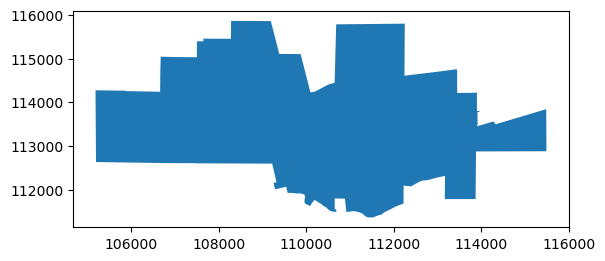

In [26]:
sf_bd_proj = study_bd.to_crs(epsg=7131)
sf_bd_proj.plot()

In [27]:
census_track2=gpd.clip(census_track1,sf_bd_proj)
census_track2.head()

GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  \
12648  G0600950253300      06      095  253300  06095253300    2533   
13249  G0601130010401      06      113  010401  06113010401  104.01   
13251  G0601130010501      06      113  010501  06113010501  105.01   
13261  G0601130010607      06      113  010607  06113010607  106.07   
13262  G0601130010608      06      113  010608  06113010608  106.08   

                  NAMELSAD  MTFCC FUNCSTAT        ALAND     AWATER  \
12648    Census Tract 2533  G5020        S  442728074.0  2198910.0   
13249  Census Tract 104.01  G5020        S  348856897.0  8188502.0   
13251  Census Tract 105.01  G5020        S   13594500.0        0.0   
13261  Census Tract 106.07  G5020        S    3538352.0        0.0   
13262  Census Tract 106.08  G5020        S    2121573.0        0.0   

          INTPTLAT      INTPTLON     Shape_Leng    Shape_Area  \
12648  +38.4198882  -121.7998024  123158.067002  4.449270e+08   
13249  +38.4284581  -121.6491713   89877.146298  3.570455e+08   
13251  +38.5369244  -121.7848197   19757.633627  1.359450e+07   
13261  +38.5407306  -121.7024346    8346.169693  3.538353e+06   
13262  +38.5412556  -121.7230816    7160.791989  2.121574e+06   

                                                geometry  
12648  MULTIPOLYGON (((110019.341 111667.333, 110026....  
13249  POLYGON ((113865.435 111805.693, 113865.830 11...  
13251  MULTIPOLYGON (((105193.571 112647.576, 105194....  
13261  POLYGON ((113861.957 113385.440, 113862.237 11...  
13262  POLYGON ((112150.914 111662.855, 112076.374 11...

In [28]:
census_track2.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Shape/Davis_City_cnesus_Tract.shp")

In [29]:
sf_bd_proj['area']=sf_bd_proj['geometry'].area*3.861e-7 # mile square
sf_bd_proj

OBJECTID CITYCODE CITY_NAME  SQ_MILES        ACRES  \
0         3     None     Davis  9.926877  6353.200981   

                                 GlobalID  SHAPE_Leng  SHAPE_Area  \
0  {8E8354F3-0188-49F2-AE1F-F1AE13B3B12E}    0.356762     0.00269   

                                            geometry       area  
0  POLYGON ((109189.169 115860.705, 109381.779 11...  10.050553

In [30]:
sf_area=sf_bd_proj[['area']].sum()
sf_area

area    10.050553
dtype: float64

In [31]:
barea_all2 = gpd.GeoDataFrame(barea_all1, crs="EPSG:4326", geometry='geometry')
barea_all3=barea_all2.to_crs(epsg=7131)
barea_all3.head()

ROAD_ID                               geometry_x   start_lon  start_lat  \
0     7898    POINT (-121.731084 38.54874530000001) -121.731084  38.548745   
1    14841   POINT (-121.69421260000001 38.5566429) -121.694213  38.556643   
2    15576          POINT (-121.8227399 38.5469839) -121.822740  38.546984   
3    15659   POINT (-121.74385640000001 38.5412802) -121.743856  38.541280   
4    15999  POINT (-121.7546551 38.540496299999994) -121.754655  38.540496   

   starting_ele                              geometry_y     end_lon  \
0     12.312861  POINT (-121.73057430000001 38.5487355) -121.730574   
1      8.930607          POINT (-121.694159 38.5565277) -121.694159   
2     23.069754         POINT (-121.8231422 38.5469857) -121.823142   
3     15.718659  POINT (-121.74343309999999 38.5413364) -121.743433   
4     14.410607   POINT (-121.754637 38.54044690000001) -121.754637   

     end_lat  ending_ele        osmid  ... FT_INT_STR TF_SEG_STR TF_INT_STR  \
0  38.548735   12.072841  {249414350}  ...          0        4.0          0   
1  38.556528    8.957235  {617716534}  ...          0          0        1.0   
2  38.546986   23.181372   {10747435}  ...          0        4.0          0   
3  38.541336   15.605118  {248096977}  ...          0        1.0        1.0   
4  38.540447   14.439425  {990990070}  ...        1.0        1.0          0   

   XWALK                                           geometry     length  \
0      0  LINESTRING (110671.553 112905.829, 110715.995 ...  44.448339   
1      0  LINESTRING (113878.653 113808.321, 113883.431 ...  13.615555   
2      0  LINESTRING (102682.700 112651.800, 102647.627 ...  35.073038   
3      0  LINESTRING (109564.470 112068.503, 109601.328 ...  37.430131   
4      0  LINESTRING (108623.643 111974.308, 108625.263 ...   5.706566   

                            starting point  \
0    POINT (-121.731084 38.54874530000001)   
1   POINT (-121.69421260000001 38.5566429)   
2          POINT (-121.8227399 38.5469839)   
3   POINT (-121.74385640000001 38.5412802)   
4  POINT (-121.7546551 38.540496299999994)   

                             ending point     slope impedance_of_link  
0  POINT (-121.73057430000001 38.5487355)  0.539999        222.241697  
1          POINT (-121.694159 38.5565277)  0.195574         54.462221  
2         POINT (-121.8231422 38.5469857)  0.318245        175.365188  
3  POINT (-121.74343309999999 38.5413364)  0.303343         74.860262  
4   POINT (-121.754637 38.54044690000001)  0.504983         11.413133  

[5 rows x 39 columns]

In [32]:
# Now lets crop the alameda area of lTS network
sf_lts=gpd.clip(barea_all3,sf_bd_proj)
sf_lts.head()

ROAD_ID                                     geometry_x   start_lon  \
1449     3520         POINT (-121.73166950000001 38.5361913) -121.731670   
1448     3521  POINT (-121.72678500000002 38.53685529999999) -121.726785   
1484     4494         POINT (-121.73166950000001 38.5361913) -121.731670   
2329     2690         POINT (-121.7318832 38.53618949999999) -121.731883   
95       2691          POINT (-121.73241299999998 38.537106) -121.732413   

      start_lat  starting_ele                                     geometry_y  \
1449  38.536191     12.471836         POINT (-121.72683249999999 38.5364609)   
1448  38.536855     14.334877         POINT (-121.72683249999999 38.5364609)   
1484  38.536191     12.471836         POINT (-121.7318832 38.53618949999999)   
2329  38.536189     12.484120  POINT (-121.73236700000001 38.53710300000001)   
95    38.537106     15.001275  POINT (-121.73236700000001 38.53710300000001)   

         end_lon    end_lat  ending_ele                 osmid  ... FT_INT_STR  \
1449 -121.726832  38.536461   14.684669            {32476247}  ...          0   
1448 -121.726832  38.536461   14.684669  {570174498,32476247}  ...          0   
1484 -121.731883  38.536189   12.484120            {32476247}  ...          0   
2329 -121.732367  38.537103   14.921537            {32476247}  ...        1.0   
95   -121.732367  38.537103   14.921537            {10746930}  ...        1.0   

     TF_SEG_STR TF_INT_STR  XWALK  \
1449        1.0          0      0   
1448        1.0          0      0   
1484        1.0          0      0   
2329        1.0          0      0   
95            0        1.0      0   

                                               geometry      length  \
1449  MULTILINESTRING ((110631.399 111511.817, 11064...  431.430894   
1448  LINESTRING (111056.705 111588.865, 111059.824 ...   47.104976   
1484  LINESTRING (110631.399 111511.817, 110622.853 ...   18.706652   
2329  LINESTRING (110612.768 111511.471, 110586.565 ...  129.328597   
95    LINESTRING (110565.780 111612.851, 110567.771 ...    4.054351   

                                     starting point  \
1449         POINT (-121.73166950000001 38.5361913)   
1448  POINT (-121.72678500000002 38.53685529999999)   
1484         POINT (-121.73166950000001 38.5361913)   
2329         POINT (-121.7318832 38.53618949999999)   
95            POINT (-121.73241299999998 38.537106)   

                                       ending point     slope  \
1449         POINT (-121.72683249999999 38.5364609)  0.512905   
1448         POINT (-121.72683249999999 38.5364609)  0.742579   
1484         POINT (-121.7318832 38.53618949999999)  0.065668   
2329  POINT (-121.73236700000001 38.53710300000001)  1.884670   
95    POINT (-121.73236700000001 38.53710300000001)  1.966718   

     impedance_of_link  
1449        862.861789  
1448         94.209953  
1484         37.413305  
2329        258.657193  
95            8.108702  

[5 rows x 39 columns]

In [33]:
# Convert the LTS shape file to graph to run the 
sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)
sf_lts_g1 =momepy.gdf_to_nx(sf_lts_g, approach='primal')

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_14276\1286791951.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_g=gpd.GeoDataFrame.explode(sf_lts)


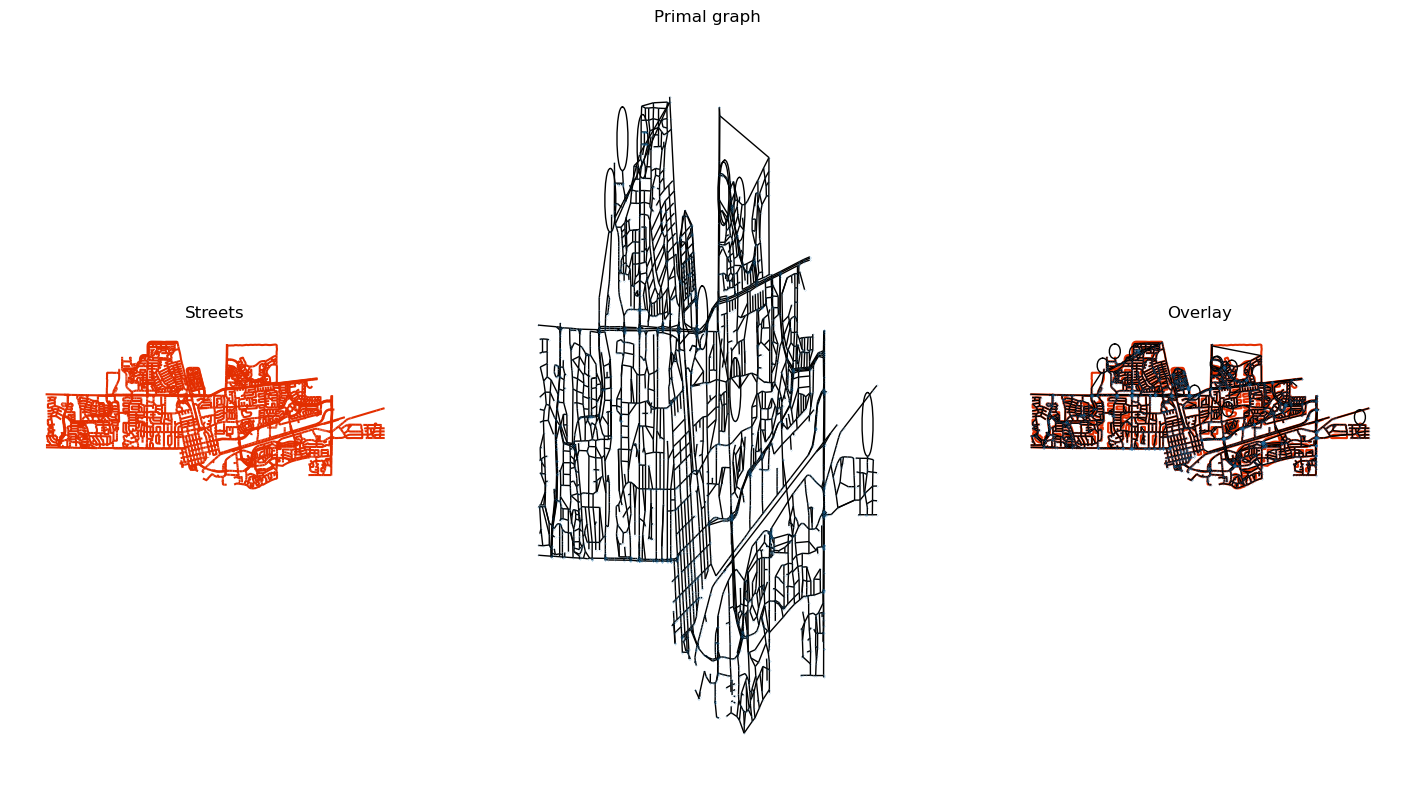

In [35]:
  f, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
  sf_lts.plot(color='#e32e00', ax=ax[0])
  for i, facet in enumerate(ax):
      facet.set_title(("Streets", "Primal graph", "Overlay")[i])
      facet.axis("off")
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[1], node_size=0.01)
  sf_lts.plot(color='#e32e00', ax=ax[2], zorder=-1)
  nx.draw(sf_lts_g1, {n:[n[0], n[1]] for n in list(sf_lts_g1.nodes)}, ax=ax[2], node_size=0.01)

<AxesSubplot:>

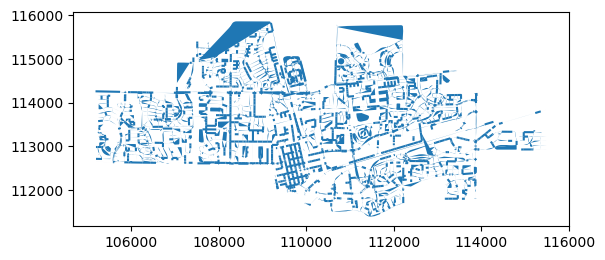

In [36]:
sf_lts['geometry'].convex_hull.plot()

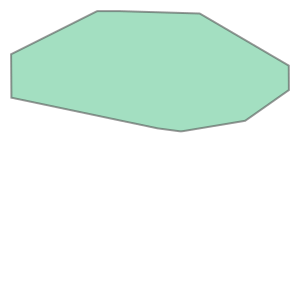

In [33]:
# Get the Convex Hull of the network
convex_hull_area = sf_lts.unary_union.convex_hull
# Show output
convex_hull_area

<AxesSubplot:>

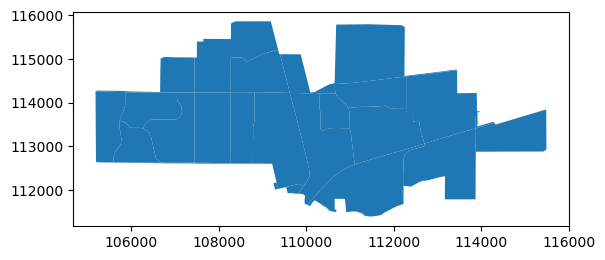

In [34]:
census_track3_sf=gpd.clip(census_track2,convex_hull_area)
census_track3_sf.plot()

In [35]:
convex_hull_area1=convex_hull_area.area
convex_hull_area1

34011948.53461462

In [36]:
# Calculate the number of Intersections
crossroad_nodes = [node for node in sf_lts_g1.nodes() if len(sf_lts_g1.edges(node)) > 2]

In [37]:
def get_number_of_elements(list):
    count = 0
    for element in list:
        count += 1
    return count

#print("Number of elements in the list: ", get_number_of_elements(list_c))

In [38]:
# Number of intersections where edge>2
NI=get_number_of_elements(crossroad_nodes)
NI

2511

# Bicycle Vs Motor Network Connectivity

<AxesSubplot:>

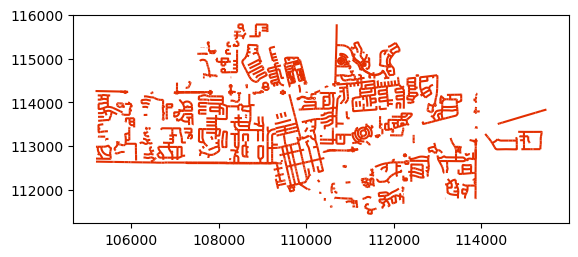

In [34]:
# Get the motorway network and bike network based on functional class of the roads
#sf_motor_network=sf_lts[sf_lts['BIKE_LANE_'].isna()]
sf_motor_network=sf_lts.loc[sf_lts['FT_BIKE_IN']=='0']
# Plot the motor Network
sf_motor_network.plot(color='#e32e00')

In [36]:
sf_motor_network.groupby(['FT_SEG_STR'])['FT_SEG_STR'].count()

FT_SEG_STR
1    1987
2      35
3      23
4     464
Name: FT_SEG_STR, dtype: int64

<AxesSubplot:>

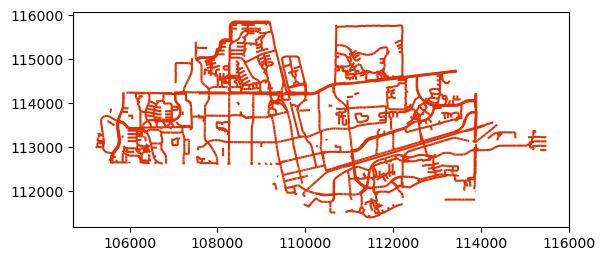

In [35]:
# Plot the Bike Network
sf_bike_network=sf_lts.loc[sf_lts['FT_BIKE_IN']!='0']
sf_bike_network.plot(color='#e32e00')

In [37]:
sf_bike_network.groupby(['FT_SEG_STR'])['FT_SEG_STR'].count()

FT_SEG_STR
1    1965
3    1379
4      28
Name: FT_SEG_STR, dtype: int64

In [41]:
input_census_tract=census_track2.reset_index()
input_census_tract.shape

(20, 17)

In [75]:
## Calculate the connectivity score for bike vs motor network condition
sf_connectivity_score (sf_motor_network,sf_bike_network)

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                1.950354e+09               1.027585e+11           52.687119

In [57]:
SF_CS=grid_connectivity_score (input_census_tract,sf_motor_network,sf_bike_network)
cs_census_track=pd.merge(SF_CS, input_census_tract, left_index=True, right_index=True)
cs_census_track.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.Ge

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                1.425425e+02               1.591381e+03           11.164253   
1                8.847216e+05               1.176346e+07           13.296231   
2                6.644384e+06               4.602068e+05            0.069263   
3                5.532289e+06               9.961891e+07           18.006816   
4                1.308214e+06               2.270401e+08          173.549677   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  \
0  12648  G0600950253300      06      095  253300  06095253300    2533   
1  13249  G0601130010401      06      113  010401  06113010401  104.01   
2  13251  G0601130010501      06      113  010501  06113010501  105.01   
3  13261  G0601130010607      06      113  010607  06113010607  106.07   
4  13262  G0601130010608      06      113  010608  06113010608  106.08   

              NAMELSAD  MTFCC FUNCSTAT        ALAND     AWATER     INTPTLAT  \
0    Census Tract 2533  G5020        S  442728074.0  2198910.0  +38.4198882   
1  Census Tract 104.01  G5020        S  348856897.0  8188502.0  +38.4284581   
2  Census Tract 105.01  G5020        S   13594500.0        0.0  +38.5369244   
3  Census Tract 106.07  G5020        S    3538352.0        0.0  +38.5407306   
4  Census Tract 106.08  G5020        S    2121573.0        0.0  +38.5412556   

       INTPTLON     Shape_Leng    Shape_Area  \
0  -121.7998024  123158.067002  4.449270e+08   
1  -121.6491713   89877.146298  3.570455e+08   
2  -121.7848197   19757.633627  1.359450e+07   
3  -121.7024346    8346.169693  3.538353e+06   
4  -121.7230816    7160.791989  2.121574e+06   

                                            geometry  
0  MULTIPOLYGON (((110019.341 111667.333, 110026....  
1  POLYGON ((113865.435 111805.693, 113865.830 11...  
2  MULTIPOLYGON (((105193.571 112647.576, 105194....  
3  POLYGON ((113861.957 113385.440, 113862.237 11...  
4  POLYGON ((112150.914 111662.855, 112076.374 11...

In [58]:
cs_census_track['Connectivity score'].median()

15.651523681187294

In [60]:
cs_census_track['Connectivity score'].mean()

41.75826379440875

In [71]:
crs = {'init': 'epsg:7131'}
gdf = gpd.GeoDataFrame(cs_census_track, crs=crs, geometry = 'geometry')
gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_B_vs_Motor_CS.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_9056\560708537.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_B_vs_Motor_CS.shp")


In [66]:
gdf ['cs_ranking']=gdf .apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf.head()

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                1.425425e+02               1.591381e+03           11.164253   
1                8.847216e+05               1.176346e+07           13.296231   
2                6.644384e+06               4.602068e+05            0.069263   
3                5.532289e+06               9.961891e+07           18.006816   
4                1.308214e+06               2.270401e+08          173.549677   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  ...  \
0  12648  G0600950253300      06      095  253300  06095253300    2533  ...   
1  13249  G0601130010401      06      113  010401  06113010401  104.01  ...   
2  13251  G0601130010501      06      113  010501  06113010501  105.01  ...   
3  13261  G0601130010607      06      113  010607  06113010607  106.07  ...   
4  13262  G0601130010608      06      113  010608  06113010608  106.08  ...   

   MTFCC FUNCSTAT        ALAND     AWATER     INTPTLAT      INTPTLON  \
0  G5020        S  442728074.0  2198910.0  +38.4198882  -121.7998024   
1  G5020        S  348856897.0  8188502.0  +38.4284581  -121.6491713   
2  G5020        S   13594500.0        0.0  +38.5369244  -121.7848197   
3  G5020        S    3538352.0        0.0  +38.5407306  -121.7024346   
4  G5020        S    2121573.0        0.0  +38.5412556  -121.7230816   

      Shape_Leng    Shape_Area  \
0  123158.067002  4.449270e+08   
1   89877.146298  3.570455e+08   
2   19757.633627  1.359450e+07   
3    8346.169693  3.538353e+06   
4    7160.791989  2.121574e+06   

                                            geometry             cs_ranking  
0  MULTIPOLYGON (((110019.341 111667.333, 110026....  excellently connected  
1  POLYGON ((113865.435 111805.693, 113865.830 11...  excellently connected  
2  MULTIPOLYGON (((105193.571 112647.576, 105194....       poorly connected  
3  POLYGON ((113861.957 113385.440, 113862.237 11...  excellently connected  
4  POLYGON ((112150.914 111662.855, 112076.374 11...  excellently connected  

[5 rows x 21 columns]

In [67]:
# Now count the census tract for Bay area by cs ranking
gdf.groupby(['cs_ranking'])['GISJOIN'].count()

cs_ranking
excellently connected    17
poorly connected          2
very well connected       1
Name: GISJOIN, dtype: int64

# Consider high Stress Vs Low Stress connectivity: using Formula "Shortest Path(LTS1+LTS2)/Shortest Path in motor network

In [38]:
# Split the network as low VS high stress network to get the connectivity by stress level
sf_motor_network_op2=sf_motor_network
sf_bike_network_op2=sf_lts.loc[sf_lts['FT_SEG_STR']<3]

In [40]:
sf_bike_network_op2.groupby(['FT_SEG_STR'])['FT_SEG_STR'].count()

FT_SEG_STR
1    3952
2      35
Name: FT_SEG_STR, dtype: int64

In [43]:
# low Vs High stress connectivity score
## Calculate the connectivity score for bike vs motor network condition
low_high_stress_CS=sf_connectivity_score (sf_motor_network_op2,sf_bike_network_op2)
low_high_stress_CS

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\2561783953.py:3: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(sf_motor_network)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\2561783953.py:14: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(sf_bike_network)


motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                1.950354e+09               5.105421e+10           26.176892

In [44]:
# Calculate the census level stress for high vs low stress network
SF_CS_hl=grid_connectivity_score (input_census_tract,sf_bike_network_op2,sf_motor_network_op2)
SF_CS_hl.head()

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd

C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd.GeoDataFrame.explode(network_bike)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:7: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_motor_g=gpd.GeoDataFrame.explode(network_motor)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\4171608999.py:20: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  sf_lts_bike_g=gpd

motor_path_weighted_length  bike_path_weighted_length  Connectivity score
0                9.985249e+02               1.425425e+02            0.142753
1                1.885601e+06               8.847216e+05            0.469199
2                5.238273e+05               6.644384e+06           12.684301
3                1.259049e+08               5.532289e+06            0.043940
4                6.230174e+07               1.308214e+06            0.020998

In [45]:
SF_CS_hl['Connectivity score'].median()

0.2674340300083675

In [46]:
cs_census_track_hl=pd.merge(SF_CS_hl, input_census_tract, left_index=True, right_index=True)
crs = {'init': 'epsg:7131'}
gdf_hl = gpd.GeoDataFrame(cs_census_track_hl, crs=crs, geometry = 'geometry')
gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Census_track_level_CS_hl.shp")

C:\Users\mmmiah\.conda\envs\geo_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\mmmiah\AppData\Local\Temp\ipykernel_34724\2063172795.py:4: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_hl.to_file("H:/Desktop/Bicycle Connectivity Project/Project-Bicycle Connectivity/Davis City Connectivity/Davis_City_Census_track_level_CS_hl.shp")


In [47]:
gdf_hl['cs_ranking']=gdf_hl.apply(lambda row:count_census_block(row['Connectivity score']),axis=1 )
gdf_hl.head()

motor_path_weighted_length  bike_path_weighted_length  Connectivity score  \
0                9.985249e+02               1.425425e+02            0.142753   
1                1.885601e+06               8.847216e+05            0.469199   
2                5.238273e+05               6.644384e+06           12.684301   
3                1.259049e+08               5.532289e+06            0.043940   
4                6.230174e+07               1.308214e+06            0.020998   

   index         GISJOIN STATEFP COUNTYFP TRACTCE        GEOID    NAME  ...  \
0  12648  G0600950253300      06      095  253300  06095253300    2533  ...   
1  13249  G0601130010401      06      113  010401  06113010401  104.01  ...   
2  13251  G0601130010501      06      113  010501  06113010501  105.01  ...   
3  13261  G0601130010607      06      113  010607  06113010607  106.07  ...   
4  13262  G0601130010608      06      113  010608  06113010608  106.08  ...   

   MTFCC FUNCSTAT        ALAND     AWATER     INTPTLAT      INTPTLON  \
0  G5020        S  442728074.0  2198910.0  +38.4198882  -121.7998024   
1  G5020        S  348856897.0  8188502.0  +38.4284581  -121.6491713   
2  G5020        S   13594500.0        0.0  +38.5369244  -121.7848197   
3  G5020        S    3538352.0        0.0  +38.5407306  -121.7024346   
4  G5020        S    2121573.0        0.0  +38.5412556  -121.7230816   

      Shape_Leng    Shape_Area  \
0  123158.067002  4.449270e+08   
1   89877.146298  3.570455e+08   
2   19757.633627  1.359450e+07   
3    8346.169693  3.538353e+06   
4    7160.791989  2.121574e+06   

                                            geometry             cs_ranking  
0  MULTIPOLYGON (((110019.341 111667.333, 110026....       poorly connected  
1  POLYGON ((113865.435 111805.693, 113865.830 11...       fairly connected  
2  MULTIPOLYGON (((105193.571 112647.576, 105194....  excellently connected  
3  POLYGON ((113861.957 113385.440, 113862.237 11...       poorly connected  
4  POLYGON ((112150.914 111662.855, 112076.374 11...       poorly connected  

[5 rows x 21 columns]

In [49]:
# Now count the census tract for Bay area by cs ranking
gdf_hl.groupby(['cs_ranking'])['cs_ranking'].count()

cs_ranking
excellently connected     2
fairly connected          5
poorly connected         10
very well connected       2
well connected            1
Name: cs_ranking, dtype: int64

# End of coding